In [27]:
import os
import random
import numpy as np
import pandas as pd
import multiprocessing
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
plt.style.use('ggplot')

DATA_PATH = '/root/Workspace/DataLake/stMary'
DATA_SAVE_PATH = '/root/Workspace/Project-RRpo-2ndStudy/dataset' 

In [2]:
# pd.read_csv(f'/root/Workspace/DataLake/stMary/6265f66dd31b9ea93535076b/pleth.csv', header=None, names=['sid', 'offset', 'pleth']).pleth.values

In [23]:
def interpolation(x, input):
    x0 = int(np.floor(x))
    y0 = input[x0]
    x1 = int(np.ceil(x))
    y1 = input[x1]
    y = (y1-y0)*(x-x0) + y0
    return y


def signal_resample(input_signal, org_fs, new_fs, method='interpolation'):
    output_signal = []
    new_x = np.arange(0, len(input_signal), org_fs/new_fs)
    
    if method == 'interpolation': 
        interp = interpolation

    for x in new_x:
        y = interp(x, input_signal)
        output_signal.append(y)

    return np.asarray(output_signal)


def generate_dataset(arg_pleth, arg_resp, fs=125, shift_factor=4):
    """
    성모병원에서 수집된 데이터의 특성상 이러한 전처리를 진행해주어야 한다.
    """
    import copy
    dataset = []
    window_size = fs * 60 # 7500
    shift = int(window_size/shift_factor)
    cpy_resp = copy.deepcopy(arg_resp)
    cpy_pleth = copy.deepcopy(arg_pleth)
    # samples_len = len(arg_pleth)

    cpy_resp['offset'] = (cpy_resp['offset']-cpy_resp['offset'].min())/1000
    size_lim = int(fs * np.ceil(cpy_resp['offset'].max()))
    cpy_pleth = cpy_pleth[:size_lim]
    shift_n_times = int((len(cpy_pleth)-window_size)/shift)+1

    samp_rr = [len(cpy_resp.loc[ (cpy_resp['offset']>=0+(int(shift/fs)*i)) & ((cpy_resp['offset']<int(window_size/fs)+(int(shift/fs)*i))) ]) for i in range(shift_n_times)]
    samp_ppg = [cpy_pleth[0+(shift*i):window_size+(shift*i)] for i in range(shift_n_times)]

    dataset = np.array([np.array([samp_ppg[i], samp_rr[i]]) for i in range(len(samp_ppg))])
    return dataset


def preprocessing(filepath, numtaps, cutoff, shift_factor, org_fs, new_fs):
    pleth = pd.read_csv(f'{filepath}/pleth.csv', header=None, names=['sid', 'offset', 'pleth']).pleth.values
    # pleths = list(map(lambda pleth: pleth.astype(np.float32), pleths))
    resp = pd.read_csv(f'{filepath}/respirationTimeline.csv', header=None, names=['sid', 'offset'])

    taps = signal.firwin(numtaps=numtaps, cutoff=cutoff, window='hamming', pass_zero=False, fs=org_fs)
    filtered_pleth = signal.filtfilt(taps, 1.0, pleth)

    windows = generate_dataset(filtered_pleth, resp, shift_factor=shift_factor) # (window.no, (pleth, resp))
    rsmp_pleths = [signal_resample(window[0], org_fs, new_fs) for window in windows]
    dataset = np.array([np.array([rsmp_pleths[i], windows[i][1]]) for i in range(len(windows))])
    return dataset

In [4]:
subjects = pd.read_csv(f'{DATA_PATH}/patients.csv')
patients = subjects.loc[subjects['diagnosis']!='0']

In [5]:
def run_process(path, id, numtaps, cutoff, shift_factor, org_fs, new_fs):
    dataset = preprocessing(filepath=f'{path}/{id}', numtaps=numtaps, cutoff=cutoff, shift_factor=shift_factor, org_fs=org_fs, new_fs=new_fs)
    print(f'{id} --> {dataset.shape}')
    return id, dataset

In [6]:
pool = multiprocessing.Pool(processes=40)
results = pool.starmap(run_process, [(DATA_PATH, pid, 2000, [0.1, 0.4], 60, 125, 30) for pid in patients.id.unique()])
pool.close()
pool.join()

62577e3cd31b9ea935344031 --> (67, 2)
625f6adbd31b9ea9353483ac --> (42, 2)
62562563d31b9ea93533e571 --> (65, 2)
625f6c7ed31b9ea935349069 --> (68, 2)
62577d8cd31b9ea9353439da --> (69, 2)625f69dcd31b9ea935347d3f --> (64, 2)

6265f090d31b9ea93534e439 --> (66, 2)
625629ead31b9ea9353405fb --> (66, 2)
6265f32ad31b9ea93534f96d --> (69, 2)
6265f66dd31b9ea93535076b --> (68, 2)
62577fd3d31b9ea935344729 --> (67, 2)
625f72dad31b9ea93534bc64 --> (66, 2)
62562e3ad31b9ea935341fa7 --> (68, 2)
6258c57cd31b9ea935347692 --> (68, 2)
6260b9f2d31b9ea93534d1d8 --> (65, 2)
6265f586d31b9ea9353500c6 --> (67, 2)6258c3f0d31b9ea935346968 --> (68, 2)

625f6be1d31b9ea9353489ce --> (67, 2)
625f75bad31b9ea93534c773 --> (66, 2)
6260bb09d31b9ea93534ddc6 --> (67, 2)
625f707cd31b9ea93534af56 --> (68, 2)6256280ad31b9ea93533f868 --> (64, 2)

62562c09d31b9ea9353412f1 --> (67, 2)
6265f160d31b9ea93534eb7c --> (64, 2)
62562b43d31b9ea935340c62 --> (68, 2)
6258c143d31b9ea9353454bd --> (67, 2)
6258c4c5d31b9ea935346fe3 --> (67, 2)62

In [14]:
np.save(f'{DATA_SAVE_PATH}/230920/stmary-preprocessed.npy', np.array(results))

### 호흡에 따른 데이터 분류

In [7]:
results = np.load(f'{DATA_SAVE_PATH}/230920/stmary-preprocessed.npy', allow_pickle=True)
print(results.shape) # (subject_id, (pleth, resp))

(100, 2)


In [8]:
fast_id = []; normal_id = []; slow_id = []
for result in results:
    pid = result[0]
    mean_resp = np.mean([resp for _, resp in result[1]])
    
    if mean_resp < 12: slow_id.append(pid)
    elif mean_resp > 18: fast_id.append(pid)
    else: normal_id.append(pid)

In [9]:
len(fast_id), len(normal_id), len(slow_id)

(48, 35, 17)

In [10]:
fast_dataset = []; normal_dataset = []; slow_dataset = []
for result in results:
    if result[0] in fast_id:
        fast_dataset.append(result)
    elif result[0] in slow_id:
        slow_dataset.append(result)
    else:
        normal_dataset.append(result)

In [11]:
len(fast_dataset), len(normal_dataset), len(slow_dataset)

(48, 35, 17)

In [66]:
np.save(f'{DATA_SAVE_PATH}/230920/stmary-preprocessed_fastRR.npy', np.array(fast_dataset))
np.save(f'{DATA_SAVE_PATH}/230920/stmary-preprocessed_normalRR.npy', np.array(normal_dataset))
np.save(f'{DATA_SAVE_PATH}/230920/stmary-preprocessed_slowRR.npy', np.array(slow_dataset))

In [26]:
fast_dataset = np.load(f'{DATA_SAVE_PATH}/230920/stmary-preprocessed_fastRR.npy', allow_pickle=True)
normal_dataset = np.load(f'{DATA_SAVE_PATH}/230920/stmary-preprocessed_normalRR.npy', allow_pickle=True)
slow_dataset = np.load(f'{DATA_SAVE_PATH}/230920/stmary-preprocessed_slowRR.npy', allow_pickle=True)

In [42]:
slow_dataset[10][1][-1]

array([array([  6.12137021,   0.3091817 ,  -5.53701154, ..., -72.51705257,
              -72.84853638, -73.29229103])                                ,
       8], dtype=object)

### Figure

PPG를 보여주자.

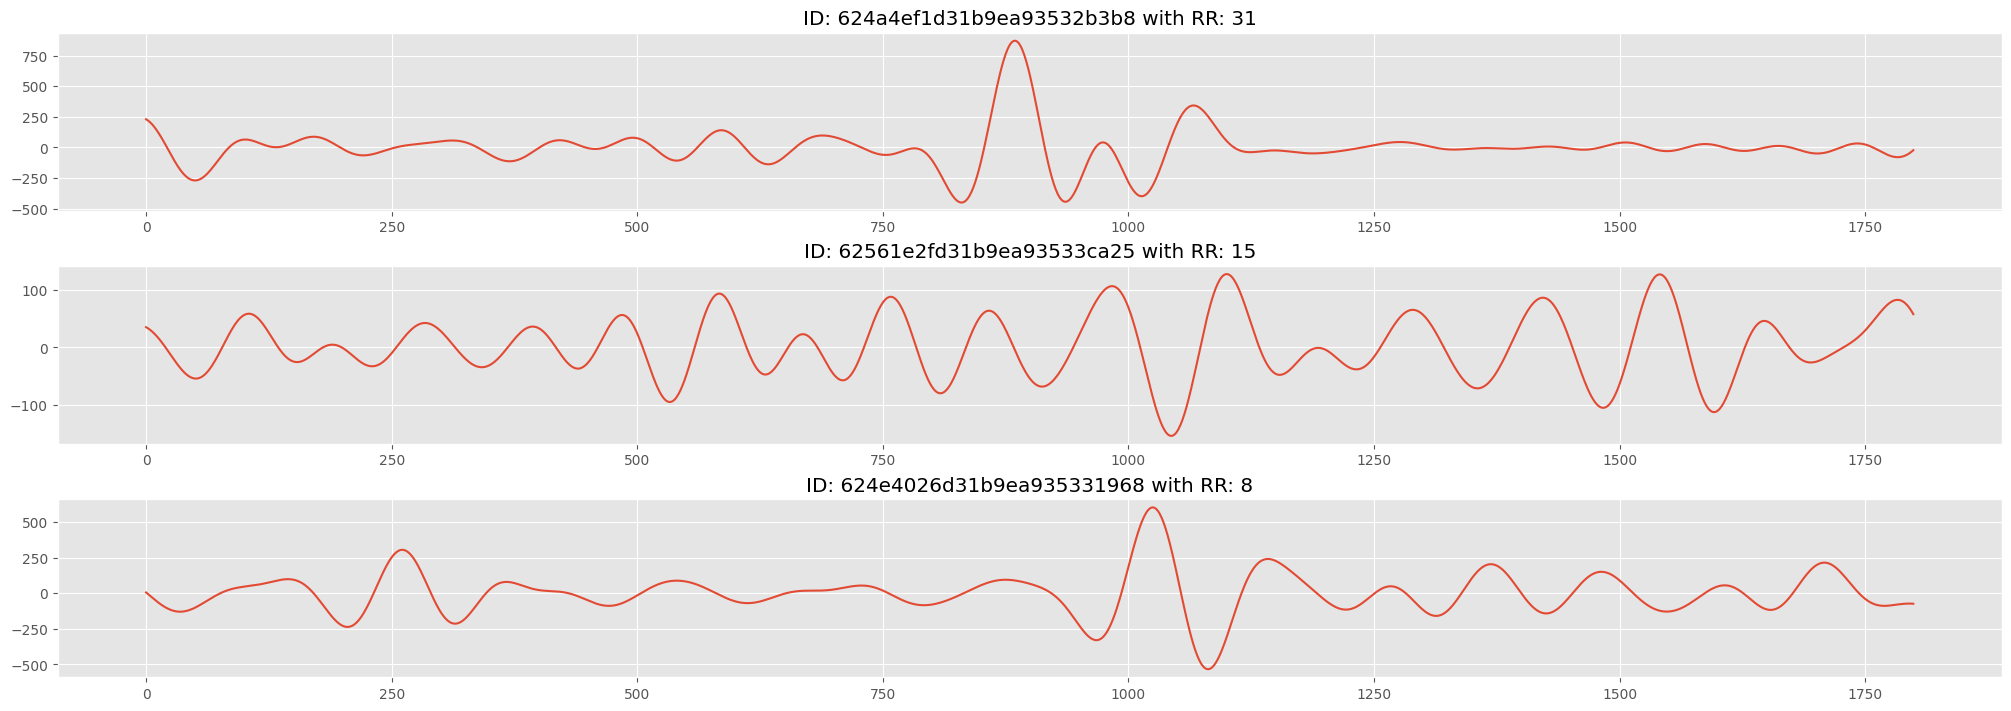

In [47]:
fig, axs = plt.subplots(3,1,figsize=(20,7), constrained_layout=True)
axs[0].plot(fast_dataset[40][1][-1,0])
axs[0].set_title(f'ID: {fast_dataset[40][0]} with RR: {fast_dataset[40][1][-1,1]}')

axs[1].plot(normal_dataset[13][1][-1,0])
axs[1].set_title(f'ID: {normal_dataset[13][0]} with RR: {normal_dataset[13][1][-1,1]}')

axs[2].plot(slow_dataset[10][1][-1,0])
axs[2].set_title(f'ID: {slow_dataset[10][0]} with RR: {slow_dataset[10][1][-1,1]}')
plt.show()

### Test Dataset

호흡 속도(빠름, 보통, 느림)에 따라 분류된 3가지 그룹에서 각각 임의로 5 ID 씩 샘플링.

총 15명의 ID에 해당하는 데이터를 Test Dataset으로 지정.

### Train & Val Dataset

이외의 나머지 85명의 ID에 해당하는 데이터는 TrainVal Dataset으로 지정.

In [12]:
test_fast_id = random.sample(fast_id, 5)
test_normal_id = random.sample(normal_id, 5)
test_slow_id = random.sample(slow_id, 5)
test_id = test_fast_id + test_normal_id + test_slow_id
print(len(test_id))

15


In [16]:
X_dataset = []
test_dataset = []
for result in results:
    if result[0] in test_id:
        test_dataset.append(result)
    else:
        X_dataset.append(result)

X_dataset = np.array(X_dataset)
test_dataset = np.array(test_dataset)

In [17]:
X_dataset.shape, test_dataset.shape

((85, 2), (15, 2))

In [18]:
np.save(f'{DATA_SAVE_PATH}/230920/stmary-test_dataset.npy', test_dataset)
np.save(f'{DATA_SAVE_PATH}/230920/stmary-trainval_dataset.npy', X_dataset)

In [20]:
test_dataset = np.load(f'{DATA_SAVE_PATH}/230920/stmary-test_dataset.npy', allow_pickle=True)
test_dataset.shape

(15, 2)